In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import load_iris, load_digits, load_wine
import sklearn.preprocessing as pp
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

from keras.activations import sigmoid,relu
from keras.layers import Dense,BatchNormalization, Activation
from keras.optimizers import RMSprop,Adam,SGD
from keras.losses import categorical_crossentropy, CategoricalCrossentropy
from keras import Sequential
CCE = CategoricalCrossentropy()

Using TensorFlow backend.


In [2]:
np.random.seed(1233)

In [3]:
def my_sigmoid(x):
    
    return ( (np.exp(x)) / (1 + np.exp(x) )  )

def my_softmax(x, axis = 1):
        
    x -= np.max(x, axis=axis, keepdims=True)
    return np.exp(x) / np.exp(x).sum(axis=axis, keepdims=True)



def Relu(x):
    return np.maximum(0,x)

def derivative_Relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x


In [4]:
iris_dataset = load_digits()
lb = LabelBinarizer()

X = iris_dataset.data
y = iris_dataset.target

lb.fit(y)
ss = StandardScaler()

data = np.concatenate((X,y.reshape(-1,1)), axis = 1)
np.random.shuffle(data)


X = data[:, :-1]

y = lb.transform( data[: , -1].reshape(-1,1) )


t1 = np.random.randn(64, 32 ) * (np.sqrt(2/64))

gamma1 = np.ones(shape = (t1.shape[1],), dtype = np.float32 ) 

B1 = np.zeros(shape = (t1.shape[1],) , dtype = np.float32)


t2 = np.random.randn(32,10) * (np.sqrt(1/32))


In [5]:
def Self_BN(X,y,t1,t2,gamma1,B1):

    losses = []
    ep = 1e-10
    N = X.shape[0]
    for i in range(2500):

        Z1 = X.dot(t1) # 5,3

        Zm = (1./N) * np.sum(Z1, axis = 0, keepdims = True);
        Zvar = (1./N) * np.sum((Z1 - Zm)**2, axis = 0, keepdims = True)
        
        Zstd = np.sqrt(Zvar + ep)

        Zn = (Z1 - Zm) / Zstd
        ZBN = gamma1 * Zn + B1 # 5,3

        A1 = Relu(ZBN) # 5,3

        Z2 = A1.dot(t2) # 5,1

        A2 = my_softmax(Z2) # 5,1

        loss = CCE(y,A2).numpy()
        losses.append(loss)

        if i%5 == 0 or i == 99:
            print(i, loss)

        error  = A2-y

        Dt2 = A1.T.dot(error) / X.shape[0]

        DL_A1 = error.dot(t2.T) 

        DZBN = DL_A1 * derivative_Relu(ZBN)
        
        

        Dgamma1 = np.sum( ( DZBN * Zn ), axis = 0, keepdims = True).reshape(32) / X.shape[0]
        DB1 = np.sum( DZBN*1. ,axis = 0, keepdims = True).reshape(32) /X.shape[0]

        one_by_N = (1./N); like_Zn = (Z1-Zm)**2 / Zstd; ones_array = np.ones((N,32))
        
        DZn = DZBN * gamma1
        
        
        DZ1 = DZn * (  (   ((1. + (one_by_N * ones_array) )*Zstd) - (like_Zn * (one_by_N *(    (ones_array) - (one_by_N*ones_array) 
            ))  ) ) / (
            Zstd)**2     )
        
        
        DZm1 = DZn * (  (Zstd - ( Zn * ((1./N) * (ones_array + 1.) ) )     )  / (
            Zstd)**2     )
        
        DZstd = -DZn * ( (Z1-Zm) / (Zstd)**2 )
        
        DZvar = DZstd * (1./(2*Zstd))
        
        DZm2 = DZvar * 2*(Z1-Zm) * (1./N)
        
        DZ2 = DZvar * ( one_by_N * (2*ones_array   + ((1./N) * ones_array)  ) )
        
        DZm = (-1.) * np.sum((DZm1 + DZm2), axis= 0, keepdims = True)
        
        DZ3 = DZm * (one_by_N * ones_array)
        
        DZ = (1.) * (DZ1 + DZ2 + DZ3)
        
        Dt1 = X.T.dot(DZ) / N
        
        
        t1 -= (0.01 * Dt1)
        t2 -= (0.01 * Dt2)

        gamma1 -= (0.01 * Dgamma1)
        B1 -= (0.01 * DB1)

    return (losses, gamma1, B1)
    
    

losses, gamma1, B1 = Self_BN(X,y, t1,t2,gamma1,B1)



0 2.5315905
5 2.4810736
10 2.4323735
15 2.3855276
20 2.3403966
25 2.2968576
30 2.2548559
35 2.2143648
40 2.1752965
45 2.1375568
50 2.1010096
55 2.0655785
60 2.0312552
65 1.9980671
70 1.9658858
75 1.9345273
80 1.9040256
85 1.8742732
90 1.8452188
95 1.8167998
99 1.7945414
100 1.7890458
105 1.762002
110 1.7356002
115 1.7098011
120 1.6845764
125 1.6598965
130 1.6357379
135 1.6119993
140 1.5886763
145 1.5657895
150 1.5432713
155 1.5211573
160 1.499426
165 1.4780465
170 1.4570062
175 1.4361922
180 1.4157231
185 1.3956125
190 1.3758303
195 1.356386
200 1.337312
205 1.3184731
210 1.2999166
215 1.2817187
220 1.2638664
225 1.2463533
230 1.229166
235 1.2123094
240 1.1957713
245 1.1795373
250 1.1636358
255 1.1480514
260 1.1327618
265 1.1177824
270 1.1030812
275 1.088667
280 1.0745405
285 1.0607151
290 1.0471736
295 1.0339155
300 1.0209286
305 1.008219
310 0.9957704
315 0.9835784
320 0.9716353
325 0.95992744
330 0.94844663
335 0.9372003
340 0.92618144
345 0.9153907
350 0.90482885
355 0.8944889
360 

In [6]:
KM = Sequential()

KM.add( Dense(32, activation= None, use_bias = False, input_shape = (64,) ) )
KM.add( BatchNormalization() )
KM.add( Activation('relu') )

KM.add( Dense(10, activation = 'softmax', use_bias = False, input_shape = (32,)) )

sg  = SGD(learning_rate = 1e-2)
KM.compile(loss='categorical_crossentropy', optimizer=sg, metrics = ['accuracy'])

KM.fit(X, y, epochs=2500, batch_size=X.shape[0])

Epoch 1/2500
1797/1797 [==============================] - 0s 62us/step - loss: 2.5553 - accuracy: 0.1046
Epoch 2/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.5379 - accuracy: 0.1074
Epoch 3/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.5208 - accuracy: 0.1107
Epoch 4/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.5039 - accuracy: 0.1102
Epoch 5/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.4872 - accuracy: 0.1146
Epoch 6/2500
1797/1797 [==============================] - 0s 3us/step - loss: 2.4707 - accuracy: 0.1163
Epoch 7/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.4544 - accuracy: 0.1180
Epoch 8/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.4383 - accuracy: 0.1213
Epoch 9/2500
1797/1797 [==============================] - 0s 2us/step - loss: 2.4223 - accuracy: 0.1241
Epoch 10/2500
1797/1797 [==============================] - 0s 2

Epoch 80/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6505 - accuracy: 0.4713
Epoch 81/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6434 - accuracy: 0.4775
Epoch 82/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6363 - accuracy: 0.4797
Epoch 83/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6293 - accuracy: 0.4830
Epoch 84/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6223 - accuracy: 0.4864
Epoch 85/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6155 - accuracy: 0.4897
Epoch 86/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6087 - accuracy: 0.4936
Epoch 87/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.6019 - accuracy: 0.4958
Epoch 88/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.5953 - accuracy: 0.4997
Epoch 89/2500
1797/1797 [==============================

Epoch 158/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2445 - accuracy: 0.6516
Epoch 159/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2407 - accuracy: 0.6528
Epoch 160/2500
1797/1797 [==============================] - 0s 1us/step - loss: 1.2369 - accuracy: 0.6544
Epoch 161/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2331 - accuracy: 0.6572
Epoch 162/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2293 - accuracy: 0.6589
Epoch 163/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2256 - accuracy: 0.6605
Epoch 164/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2218 - accuracy: 0.6617
Epoch 165/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2181 - accuracy: 0.6622
Epoch 166/2500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2144 - accuracy: 0.6661
Epoch 167/2500
1797/1797 [====================

Epoch 236/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9973 - accuracy: 0.7863
Epoch 237/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9947 - accuracy: 0.7863
Epoch 238/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9921 - accuracy: 0.7863
Epoch 239/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9895 - accuracy: 0.7885
Epoch 240/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9869 - accuracy: 0.7896
Epoch 241/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9843 - accuracy: 0.7896
Epoch 242/2500
1797/1797 [==============================] - 0s 1us/step - loss: 0.9817 - accuracy: 0.7908
Epoch 243/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9791 - accuracy: 0.7930
Epoch 244/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.9766 - accuracy: 0.7941
Epoch 245/2500
1797/1797 [====================

Epoch 314/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8196 - accuracy: 0.8436
Epoch 315/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8176 - accuracy: 0.8453
Epoch 316/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8157 - accuracy: 0.8459
Epoch 317/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8137 - accuracy: 0.8459
Epoch 318/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8118 - accuracy: 0.8470
Epoch 319/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8099 - accuracy: 0.8475
Epoch 320/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8079 - accuracy: 0.8481
Epoch 321/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8060 - accuracy: 0.8497
Epoch 322/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.8041 - accuracy: 0.8503
Epoch 323/2500
1797/1797 [====================

Epoch 392/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6860 - accuracy: 0.8848
Epoch 393/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6845 - accuracy: 0.8848
Epoch 394/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6830 - accuracy: 0.8854
Epoch 395/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6816 - accuracy: 0.8859
Epoch 396/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6801 - accuracy: 0.8859
Epoch 397/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6786 - accuracy: 0.8870
Epoch 398/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6772 - accuracy: 0.8876
Epoch 399/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.6757 - accuracy: 0.8881
Epoch 400/2500
1797/1797 [==============================] - 0s 3us/step - loss: 0.6743 - accuracy: 0.8881
Epoch 401/2500
1797/1797 [====================

Epoch 470/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5853 - accuracy: 0.9015
Epoch 471/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5842 - accuracy: 0.9015
Epoch 472/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5831 - accuracy: 0.9015
Epoch 473/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5819 - accuracy: 0.9015
Epoch 474/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5808 - accuracy: 0.9015
Epoch 475/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5797 - accuracy: 0.9015
Epoch 476/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5786 - accuracy: 0.9021
Epoch 477/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5775 - accuracy: 0.9021
Epoch 478/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5764 - accuracy: 0.9021
Epoch 479/2500
1797/1797 [====================

Epoch 548/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5081 - accuracy: 0.9154
Epoch 549/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5072 - accuracy: 0.9165
Epoch 550/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5063 - accuracy: 0.9165
Epoch 551/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5055 - accuracy: 0.9160
Epoch 552/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5046 - accuracy: 0.9160
Epoch 553/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5037 - accuracy: 0.9160
Epoch 554/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5029 - accuracy: 0.9160
Epoch 555/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5020 - accuracy: 0.9160
Epoch 556/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.5012 - accuracy: 0.9160
Epoch 557/2500
1797/1797 [====================

Epoch 626/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4477 - accuracy: 0.9232
Epoch 627/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4470 - accuracy: 0.9232
Epoch 628/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4463 - accuracy: 0.9238
Epoch 629/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4456 - accuracy: 0.9238
Epoch 630/2500
1797/1797 [==============================] - 0s 3us/step - loss: 0.4449 - accuracy: 0.9243
Epoch 631/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4443 - accuracy: 0.9243
Epoch 632/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4436 - accuracy: 0.9249
Epoch 633/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4429 - accuracy: 0.9249
Epoch 634/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.4422 - accuracy: 0.9249
Epoch 635/2500
1797/1797 [====================

Epoch 704/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3995 - accuracy: 0.9299
Epoch 705/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3989 - accuracy: 0.9304
Epoch 706/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3984 - accuracy: 0.9304
Epoch 707/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3978 - accuracy: 0.9304
Epoch 708/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3973 - accuracy: 0.9304
Epoch 709/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3967 - accuracy: 0.9316
Epoch 710/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3962 - accuracy: 0.9316
Epoch 711/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3956 - accuracy: 0.9321
Epoch 712/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3951 - accuracy: 0.9321
Epoch 713/2500
1797/1797 [====================

Epoch 782/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3605 - accuracy: 0.9405
Epoch 783/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3600 - accuracy: 0.9405
Epoch 784/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3596 - accuracy: 0.9405
Epoch 785/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3591 - accuracy: 0.9405
Epoch 786/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3587 - accuracy: 0.9405
Epoch 787/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3582 - accuracy: 0.9405
Epoch 788/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3578 - accuracy: 0.9399
Epoch 789/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3573 - accuracy: 0.9399
Epoch 790/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3569 - accuracy: 0.9399
Epoch 791/2500
1797/1797 [====================

Epoch 860/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3283 - accuracy: 0.9427
Epoch 861/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3280 - accuracy: 0.9427
Epoch 862/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3276 - accuracy: 0.9427
Epoch 863/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3272 - accuracy: 0.9427
Epoch 864/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3268 - accuracy: 0.9427
Epoch 865/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3265 - accuracy: 0.9427
Epoch 866/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3261 - accuracy: 0.9427
Epoch 867/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3257 - accuracy: 0.9427
Epoch 868/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3254 - accuracy: 0.9421
Epoch 869/2500
1797/1797 [====================

Epoch 938/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3016 - accuracy: 0.9455
Epoch 939/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3013 - accuracy: 0.9455
Epoch 940/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3010 - accuracy: 0.9455
Epoch 941/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3007 - accuracy: 0.9455
Epoch 942/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3004 - accuracy: 0.9455
Epoch 943/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.3001 - accuracy: 0.9455
Epoch 944/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2998 - accuracy: 0.9455
Epoch 945/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2995 - accuracy: 0.9455
Epoch 946/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2991 - accuracy: 0.9455
Epoch 947/2500
1797/1797 [====================

Epoch 1016/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2791 - accuracy: 0.9510
Epoch 1017/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2788 - accuracy: 0.9510
Epoch 1018/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2786 - accuracy: 0.9510
Epoch 1019/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2783 - accuracy: 0.9510
Epoch 1020/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2780 - accuracy: 0.9510
Epoch 1021/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2778 - accuracy: 0.9510
Epoch 1022/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2775 - accuracy: 0.9510
Epoch 1023/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2772 - accuracy: 0.9510
Epoch 1024/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2770 - accuracy: 0.9510
Epoch 1025/2500
1797/1797 [==========

Epoch 1093/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2599 - accuracy: 0.9549
Epoch 1094/2500
1797/1797 [==============================] - 0s 3us/step - loss: 0.2597 - accuracy: 0.9549
Epoch 1095/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2594 - accuracy: 0.9549
Epoch 1096/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2592 - accuracy: 0.9549
Epoch 1097/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2590 - accuracy: 0.9549
Epoch 1098/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2587 - accuracy: 0.9549
Epoch 1099/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2585 - accuracy: 0.9549
Epoch 1100/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2583 - accuracy: 0.9549
Epoch 1101/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2580 - accuracy: 0.9549
Epoch 1102/2500
1797/1797 [==========

Epoch 1170/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2431 - accuracy: 0.9583
Epoch 1171/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2429 - accuracy: 0.9583
Epoch 1172/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2427 - accuracy: 0.9583
Epoch 1173/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2425 - accuracy: 0.9583
Epoch 1174/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2423 - accuracy: 0.9583
Epoch 1175/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2421 - accuracy: 0.9583
Epoch 1176/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2419 - accuracy: 0.9583
Epoch 1177/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2417 - accuracy: 0.9583
Epoch 1178/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2415 - accuracy: 0.9583
Epoch 1179/2500
1797/1797 [==========

Epoch 1247/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2284 - accuracy: 0.9588
Epoch 1248/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2283 - accuracy: 0.9588
Epoch 1249/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2281 - accuracy: 0.9588
Epoch 1250/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2279 - accuracy: 0.9588
Epoch 1251/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2277 - accuracy: 0.9588
Epoch 1252/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2275 - accuracy: 0.9588
Epoch 1253/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2274 - accuracy: 0.9588
Epoch 1254/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2272 - accuracy: 0.9588
Epoch 1255/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2270 - accuracy: 0.9588
Epoch 1256/2500
1797/1797 [==========

Epoch 1324/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2155 - accuracy: 0.9610
Epoch 1325/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2153 - accuracy: 0.9610
Epoch 1326/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2152 - accuracy: 0.9610
Epoch 1327/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2150 - accuracy: 0.9610
Epoch 1328/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2148 - accuracy: 0.9610
Epoch 1329/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2147 - accuracy: 0.9616
Epoch 1330/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2145 - accuracy: 0.9616
Epoch 1331/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2144 - accuracy: 0.9616
Epoch 1332/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2142 - accuracy: 0.9616
Epoch 1333/2500
1797/1797 [==========

Epoch 1401/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2039 - accuracy: 0.9638
Epoch 1402/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2038 - accuracy: 0.9638
Epoch 1403/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2036 - accuracy: 0.9638
Epoch 1404/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2035 - accuracy: 0.9644
Epoch 1405/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2033 - accuracy: 0.9644
Epoch 1406/2500
1797/1797 [==============================] - 0s 1us/step - loss: 0.2032 - accuracy: 0.9644
Epoch 1407/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2031 - accuracy: 0.9649
Epoch 1408/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.2029 - accuracy: 0.9649
Epoch 1409/2500
1797/1797 [==============================] - 0s 1us/step - loss: 0.2028 - accuracy: 0.9649
Epoch 1410/2500
1797/1797 [==========

Epoch 1478/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1936 - accuracy: 0.9666
Epoch 1479/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1935 - accuracy: 0.9666
Epoch 1480/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1933 - accuracy: 0.9666
Epoch 1481/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1932 - accuracy: 0.9666
Epoch 1482/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1931 - accuracy: 0.9666
Epoch 1483/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1930 - accuracy: 0.9666
Epoch 1484/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1928 - accuracy: 0.9666
Epoch 1485/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1927 - accuracy: 0.9666
Epoch 1486/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1926 - accuracy: 0.9666
Epoch 1487/2500
1797/1797 [==========

Epoch 1555/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1843 - accuracy: 0.9688
Epoch 1556/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1842 - accuracy: 0.9688
Epoch 1557/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1841 - accuracy: 0.9688
Epoch 1558/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1840 - accuracy: 0.9694
Epoch 1559/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1839 - accuracy: 0.9694
Epoch 1560/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1838 - accuracy: 0.9694
Epoch 1561/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1837 - accuracy: 0.9694
Epoch 1562/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1836 - accuracy: 0.9694
Epoch 1563/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1834 - accuracy: 0.9694
Epoch 1564/2500
1797/1797 [==========

Epoch 1632/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1760 - accuracy: 0.9705
Epoch 1633/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1759 - accuracy: 0.9705
Epoch 1634/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1758 - accuracy: 0.9705
Epoch 1635/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1757 - accuracy: 0.9705
Epoch 1636/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1756 - accuracy: 0.9705
Epoch 1637/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1755 - accuracy: 0.9705
Epoch 1638/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1754 - accuracy: 0.9705
Epoch 1639/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1753 - accuracy: 0.9705
Epoch 1640/2500
1797/1797 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9705
Epoch 1641/2500
1797/1797 [==========

Epoch 1709/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1685 - accuracy: 0.9722
Epoch 1710/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1684 - accuracy: 0.9727
Epoch 1711/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1683 - accuracy: 0.9727
Epoch 1712/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1682 - accuracy: 0.9727
Epoch 1713/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1681 - accuracy: 0.9727
Epoch 1714/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1680 - accuracy: 0.9727
Epoch 1715/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1679 - accuracy: 0.9727
Epoch 1716/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1678 - accuracy: 0.9727
Epoch 1717/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1677 - accuracy: 0.9727
Epoch 1718/2500
1797/1797 [==========

Epoch 1786/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1616 - accuracy: 0.9738
Epoch 1787/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1615 - accuracy: 0.9738
Epoch 1788/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1614 - accuracy: 0.9738
Epoch 1789/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1613 - accuracy: 0.9738
Epoch 1790/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1612 - accuracy: 0.9738
Epoch 1791/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1611 - accuracy: 0.9738
Epoch 1792/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1610 - accuracy: 0.9738
Epoch 1793/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1610 - accuracy: 0.9738
Epoch 1794/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1609 - accuracy: 0.9738
Epoch 1795/2500
1797/1797 [==========

Epoch 1863/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1552 - accuracy: 0.9755
Epoch 1864/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1551 - accuracy: 0.9755
Epoch 1865/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1550 - accuracy: 0.9755
Epoch 1866/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1550 - accuracy: 0.9755
Epoch 1867/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1549 - accuracy: 0.9755
Epoch 1868/2500
1797/1797 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9755
Epoch 1869/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1547 - accuracy: 0.9755
Epoch 1870/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1546 - accuracy: 0.9755
Epoch 1871/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1546 - accuracy: 0.9755
Epoch 1872/2500
1797/1797 [==========

Epoch 1940/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1493 - accuracy: 0.9761
Epoch 1941/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1493 - accuracy: 0.9761
Epoch 1942/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1492 - accuracy: 0.9761
Epoch 1943/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1491 - accuracy: 0.9761
Epoch 1944/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1491 - accuracy: 0.9761
Epoch 1945/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1490 - accuracy: 0.9761
Epoch 1946/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1489 - accuracy: 0.9761
Epoch 1947/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1488 - accuracy: 0.9761
Epoch 1948/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1488 - accuracy: 0.9761
Epoch 1949/2500
1797/1797 [==========

Epoch 2017/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1439 - accuracy: 0.9777
Epoch 2018/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1439 - accuracy: 0.9777
Epoch 2019/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1438 - accuracy: 0.9777
Epoch 2020/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1437 - accuracy: 0.9777
Epoch 2021/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1437 - accuracy: 0.9777
Epoch 2022/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1436 - accuracy: 0.9777
Epoch 2023/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1435 - accuracy: 0.9777
Epoch 2024/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1435 - accuracy: 0.9777
Epoch 2025/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1434 - accuracy: 0.9777
Epoch 2026/2500
1797/1797 [==========

Epoch 2094/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1390 - accuracy: 0.9789
Epoch 2095/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1389 - accuracy: 0.9789
Epoch 2096/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1388 - accuracy: 0.9789
Epoch 2097/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1388 - accuracy: 0.9789
Epoch 2098/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1387 - accuracy: 0.9789
Epoch 2099/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1386 - accuracy: 0.9789
Epoch 2100/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1386 - accuracy: 0.9789
Epoch 2101/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1385 - accuracy: 0.9789
Epoch 2102/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1385 - accuracy: 0.9789
Epoch 2103/2500
1797/1797 [==========

Epoch 2171/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1343 - accuracy: 0.9794
Epoch 2172/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1343 - accuracy: 0.9794
Epoch 2173/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1342 - accuracy: 0.9794
Epoch 2174/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1341 - accuracy: 0.9794
Epoch 2175/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1341 - accuracy: 0.9794
Epoch 2176/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1340 - accuracy: 0.9794
Epoch 2177/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1340 - accuracy: 0.9794
Epoch 2178/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1339 - accuracy: 0.9794
Epoch 2179/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1339 - accuracy: 0.9794
Epoch 2180/2500
1797/1797 [==========

Epoch 2248/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1300 - accuracy: 0.9800
Epoch 2249/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1299 - accuracy: 0.9800
Epoch 2250/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1299 - accuracy: 0.9800
Epoch 2251/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1298 - accuracy: 0.9800
Epoch 2252/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1298 - accuracy: 0.9800
Epoch 2253/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1297 - accuracy: 0.9800
Epoch 2254/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1297 - accuracy: 0.9800
Epoch 2255/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1296 - accuracy: 0.9800
Epoch 2256/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1296 - accuracy: 0.9800
Epoch 2257/2500
1797/1797 [==========

Epoch 2325/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1260 - accuracy: 0.9805
Epoch 2326/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1259 - accuracy: 0.9805
Epoch 2327/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1259 - accuracy: 0.9805
Epoch 2328/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1258 - accuracy: 0.9805
Epoch 2329/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1258 - accuracy: 0.9805
Epoch 2330/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1257 - accuracy: 0.9805
Epoch 2331/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1257 - accuracy: 0.9805
Epoch 2332/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1256 - accuracy: 0.9805
Epoch 2333/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1256 - accuracy: 0.9805
Epoch 2334/2500
1797/1797 [==========

Epoch 2402/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1222 - accuracy: 0.9816
Epoch 2403/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1221 - accuracy: 0.9816
Epoch 2404/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1221 - accuracy: 0.9816
Epoch 2405/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1220 - accuracy: 0.9816
Epoch 2406/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1220 - accuracy: 0.9816
Epoch 2407/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1219 - accuracy: 0.9822
Epoch 2408/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1219 - accuracy: 0.9822
Epoch 2409/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1218 - accuracy: 0.9822
Epoch 2410/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1218 - accuracy: 0.9822
Epoch 2411/2500
1797/1797 [==========

Epoch 2479/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1186 - accuracy: 0.9827
Epoch 2480/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1185 - accuracy: 0.9827
Epoch 2481/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1185 - accuracy: 0.9827
Epoch 2482/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1185 - accuracy: 0.9827
Epoch 2483/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1184 - accuracy: 0.9827
Epoch 2484/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1184 - accuracy: 0.9827
Epoch 2485/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1183 - accuracy: 0.9827
Epoch 2486/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1183 - accuracy: 0.9827
Epoch 2487/2500
1797/1797 [==============================] - 0s 2us/step - loss: 0.1182 - accuracy: 0.9827
Epoch 2488/2500
1797/1797 [==========

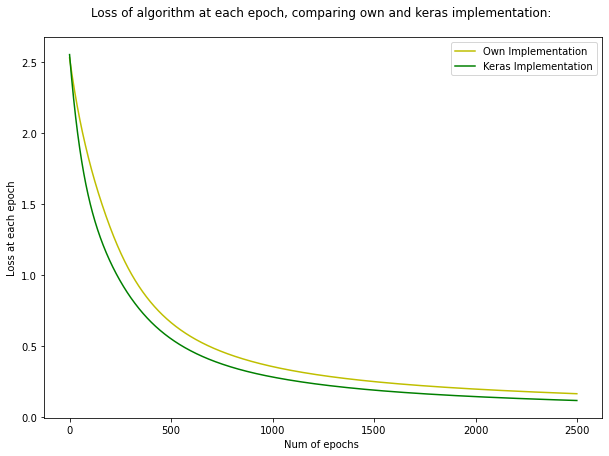

In [7]:

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(losses, color = 'y')
plt.plot(KM.history.history["loss"], color = 'g')
plt.legend(["Own Implementation", "Keras Implementation"])
plt.title("Loss of algorithm at each epoch, comparing own and keras implementation: \n")
plt.xlabel("Num of epochs ")
plt.ylabel("Loss at each epoch")

plt.show()



In [8]:
BNLayer = KM.get_layer(index = 1)

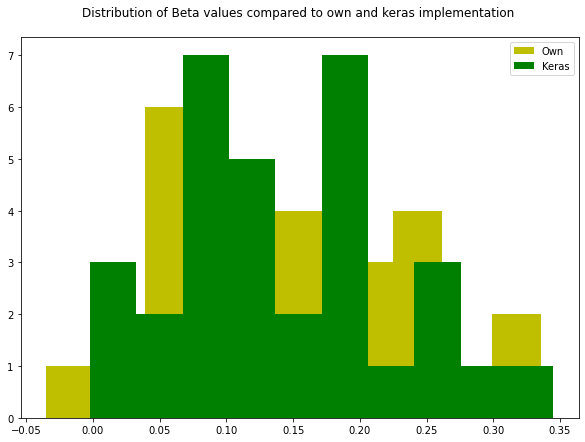

In [9]:
plt.hist(B1, color = 'y')
plt.hist(BNLayer.beta.numpy(), color = 'g')
plt.title("Distribution of Beta values compared to own and keras implementation \n")
plt.legend(["Own", "Keras"])

plt.show()

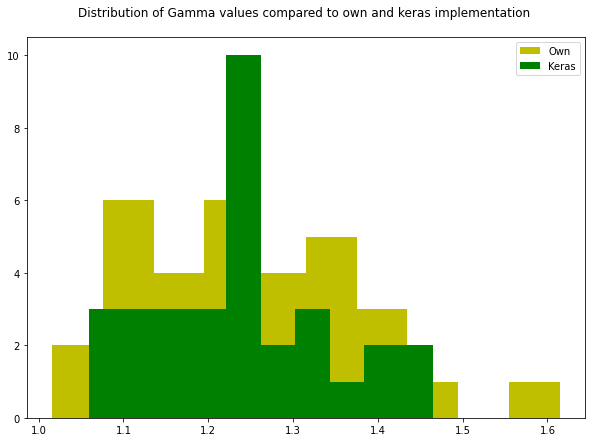

In [10]:
plt.hist(gamma1, color = 'y')
plt.hist(BNLayer.gamma.numpy(), color = 'g')
plt.title("Distribution of Gamma values compared to own and keras implementation \n")

plt.legend(["Own", "Keras"])

plt.show()

In [11]:
first_layer = KM.get_layer(index = 0)
first_layer_weights = first_layer.weights[0].numpy()

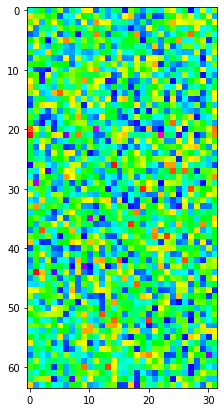

In [12]:
plt.imshow(first_layer_weights,
           interpolation='nearest', cmap=cm.gist_rainbow)
plt.show()

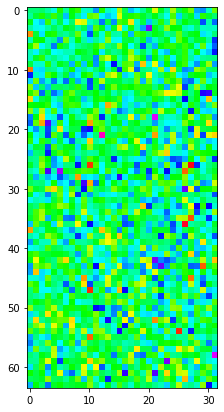

In [13]:
plt.imshow(t1,
           interpolation='nearest', cmap=cm.gist_rainbow)
plt.show()